In [80]:
from coffee_py import *
from sklearn.preprocessing import OrdinalEncoder

In [81]:
with open('coffee_data.pkl', 'rb') as f:
    data = pickle.load(f)
with open('coffee_pre.pkl', 'rb') as f:
    pre = pickle.load(f)

In [82]:
pre

ColumnTransformer(remainder='passthrough',
                  transformers=[('age',
                                 OrdinalEncoder(categories=[['<18 years old',
                                                             '18-24 years old',
                                                             '25-34 years old',
                                                             '35-44 years old',
                                                             '45-54 years '
                                                             'old55-64 years '
                                                             'old',
                                                             '>65 years old']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['age']),
                                ('cups',
                                 FunctionTransformer(func=<function cups_clean at 0x7931c944f9c0>),
                                 ['cups']),
                                ('str...
                                ('most_willing',
                                 FunctionTransformer(func=<function most_willing_clean at 0x7931bdc289a0>),
                                 ['most_willing']),
                                ('brew',
                                 FunctionTransformer(func=<function brew_clean at 0x7931bdc28ae0>),
                                 ['brew']),
                                ('favorite',
                                 FunctionTransformer(func=<function fav_clean at 0x7931bdc28b80>),
                                 ['favorite']),
                                ('additions',
                                 FunctionTransformer(func=<function add_clean at 0x7931bdc28c20>),
                                 ['additions'])])

In [83]:
data.head()

age cups                                         brew  \
0  18-24 years old  NaN                                          NaN   
1  25-34 years old  NaN  Pod/capsule machine (e.g. Keurig/Nespresso)   
2  25-34 years old  NaN                          Bean-to-cup machine   
3  35-44 years old  NaN     Coffee brewing machine (e.g. Mr. Coffee)   
4  25-34 years old  NaN                                    Pour over   

              favorite                            additions strength caffeine  \
0  Regular drip coffee                      No - just black      NaN      NaN   
1          Iced coffee  Sugar or sweetener, No - just black      NaN      NaN   
2  Regular drip coffee                      No - just black      NaN      NaN   
3          Iced coffee            No - just black, Cinnamon      NaN      NaN   
4                Latte                      No - just black      NaN      NaN   

   expertise most_willing gender prefer_overall  
0        NaN          NaN    NaN            NaN  
1        NaN          NaN    NaN            NaN  
2        NaN          NaN    NaN            NaN  
3        NaN          NaN    NaN            NaN  
4        NaN          NaN    NaN            NaN

In [84]:
x = data.drop("prefer_overall" , axis = 1)
y = data["prefer_overall"]
y.value_counts()

prefer_overall
Coffee D    1385
Coffee A     818
Coffee C     784
Coffee B     783
Name: count, dtype: int64

In [85]:
y.fillna(y.mode()[0], inplace=True)
print(y.isnull().sum())
# We are grouping Light Roasts (A & D) into 0, Medium into 1, Dark into 2
y= y.map({"Coffee A": 0, "Coffee B": 1, "Coffee C": 2, "Coffee D": 0})
#XGBoost is very strict: even if you convert labels to numbers, it requires the categories to start at 0

0


In [86]:
y.value_counts()

prefer_overall
0    2475
2     784
1     783
Name: count, dtype: int64

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)

In [88]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3233, 10)
(809, 10)
(3233,)
(809,)


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [90]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=12),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [91]:
results = []
models.items()  #gives us list of tuples of key, value pairs

dict_items([('Logistic Regression', LogisticRegression(max_iter=1000)), ('Random Forest', RandomForestClassifier(random_state=12)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...))])

In [92]:
from sklearn.pipeline import Pipeline
for name,model in models.items():
    # Create a temporary pipeline with the current model
    current_pipeline= Pipeline(steps=[
        ('preprocessor',pre), # Your ColumnTransformer
        ('classifier',model)
    ])

    # Train
    current_pipeline.fit(x_train,y_train)

    # Predict
    pred = current_pipeline.predict(x_test)

    # Score
    ac = accuracy_score(y_test,pred)
    f1 = f1_score(y_test,pred,average='weighted')
    print(f"Model: {name} : \n")
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))

    # Append to results
    results.append({
        'Model': name,
        'Accuracy': ac,
        'F1 Score': f1
    })
final_comparison = pd.DataFrame(results)



DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean
DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean
Model: Logistic Regression : 

[[485  10  11]
 [138  12   7]
 [137   6   3]]
              precision    recall  f1-score   support

           0       0.64      0.96      0.77       506
           1       0.43      0.08      0.13       157
           2       0.14      0.02      0.04       146

    accuracy                           0.62       809
   macro avg       0.40      0.35      0.31       809
weighted avg       0.51      0.62      0.51       809

DEBUG: Running cups_clean
DEBUG:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:10:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean
Model: XGBoost : 

[[436  27  43]
 [106  21  30]
 [104  25  17]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.76       506
           1       0.29      0.13      0.18       157
           2       0.19      0.12      0.14       146

    accuracy                           0.59       809
   macro avg       0.38      0.37      0.36       809
weighted avg       0.51      0.59      0.53       809



In [93]:
final_comparison

Model  Accuracy  F1 Score
0  Logistic Regression  0.618047  0.510886
1        Random Forest  0.562423  0.522430
2              XGBoost  0.585909  0.534879

Interpretation of the Results :

Logistic Regression : Achieves the highest accuracy by leaning heavily on the majority class (Coffee D). Poor F1 score suggests that it is unable to detect rarer choices.

XGBoost : While overall accuracy is slightly lower, the higher F1-score proves that it is better at distinguishing between all four coffee types, not just the most common one.

Random Forest : Plays in between.

I will go with XGBoost as it proves that XGBoost is actually learning the "flavor profiles" of the different coffees rather than just memorizing the most common answer. XGBoost (Gradient Boosting) is designed to find these "if-this-then-that" patterns better than Logistic Regression. Since XGBoost is already showing the most "intelligence" (high F1), we can likely push its accuracy past 45% or 50% by tuning its Hyperparameters.

In [94]:
from sklearn.utils.class_weight import compute_sample_weight

# 1. Calculate the balanced weights for your 4 coffee classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [95]:
x_train_transformed = current_pipeline.named_steps['preprocessor'].fit_transform(x_train)

current_pipeline.named_steps['classifier'].fit(
    x_train_transformed,
    y_train,
    sample_weight=sample_weights
)

DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:10:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [96]:
y_pred = current_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       506
           1       0.29      0.27      0.28       157
           2       0.18      0.24      0.21       146

    accuracy                           0.51       809
   macro avg       0.39      0.39      0.39       809
weighted avg       0.53      0.51      0.52       809



In [97]:
from sklearn.model_selection import RandomizedSearchCV

# Define the "Search Space"
# Note the 'classifier__' prefix to talk to your model inside the pipeline
param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1.0]
}

# Use 'f1_macro' as the scorer to keep the classes balanced!
tuned_search = RandomizedSearchCV(
    current_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

tuned_search.fit(x_train, y_train)

# This is your new, best model
best_pipeline = tuned_search.best_estimator_

DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:10:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [98]:
y_pred = best_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       506
           1       0.36      0.15      0.21       157
           2       0.19      0.10      0.13       146

    accuracy                           0.59       809
   macro avg       0.40      0.37      0.37       809
weighted avg       0.52      0.59      0.53       809



In [99]:
final_comparison.loc[len(final_comparison)] = ['XGBoost_Tuned', accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')]

In [100]:
final_comparison

Model  Accuracy  F1 Score
0  Logistic Regression  0.618047  0.510886
1        Random Forest  0.562423  0.522430
2              XGBoost  0.585909  0.534879
3        XGBoost_Tuned  0.588381  0.365089

I will go with the base XGBoost Model.

This classification report is a perfect example of the "Accuracy Trap." The Accuracy went up to 0.60, which looks great on a slide, but the Macro F1-Score dropped because the model became a "bully." It realized that since 62% of your data is Class 0, it can get a high score just by guessing "Class 0" almost all the time.

The "Base" Model was actually "braver": Even though its accuracy was lower (0.51), it had a recall of 0.27 and 0.24 for the minority classes. It was trying harder to find them.

In [101]:
cols = ['age', 'cups', 'strength', 'caffeine', 'expertise','gender',
       'most_willing', 'brew_pour_over', 'brew_espresso',
       'brew_french_press', 'brew_drip_coffee', 'brew_aeropress',
       'brew_pod/capsule', 'brew_instant_coffee', 'favorite', 'adds_milk', 'adds_sugar',
       'adds_syrup', 'adds_sweetener', 'adds_creamer']

In [102]:
x_train_final = pre.fit_transform(x_train)
x_train_final


DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean


array([[2., 2., 3., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       [3., 2., 2., ..., 0., 1., 1.],
       ...,
       [1., 2., 2., ..., 0., 0., 1.],
       [3., 2., 2., ..., 0., 0., 0.],
       [2., 2., 3., ..., 0., 0., 0.]])

In [103]:
x_test_final = pre.transform(x_test)

DEBUG: Running cups_clean
DEBUG: Running strength_clean
DEBUG: Running caffeine_clean
DEBUG: Running expertise_clean
DEBUG: Running gender_clean
DEBUG: Running most_willing_clean
DEBUG: Running brew_clean
DEBUG: Running fav_clean
DEBUG: Running add_clean


In [104]:
cols

['age',
 'cups',
 'strength',
 'caffeine',
 'expertise',
 'gender',
 'most_willing',
 'brew_pour_over',
 'brew_espresso',
 'brew_french_press',
 'brew_drip_coffee',
 'brew_aeropress',
 'brew_pod/capsule',
 'brew_instant_coffee',
 'favorite',
 'adds_milk',
 'adds_sugar',
 'adds_syrup',
 'adds_sweetener',
 'adds_creamer']

In [105]:
x_train_final = pd.DataFrame(x_train_final, columns=cols)
x_train_final.head()

age  cups  strength  caffeine  expertise  gender  most_willing  \
0  2.0   2.0       3.0       2.0        7.0     0.0           3.0   
1  2.0   2.0       2.0       2.0        7.0     0.0           2.0   
2  3.0   2.0       2.0       2.0        6.0     0.0           3.0   
3  2.0   2.0       3.0       2.0        5.0     0.0           2.0   
4  3.0   2.0       3.0       2.0        7.0     0.0           3.0   

   brew_pour_over  brew_espresso  brew_french_press  brew_drip_coffee  \
0             1.0            0.0                0.0               0.0   
1             1.0            0.0                1.0               0.0   
2             1.0            1.0                0.0               0.0   
3             0.0            1.0                1.0               0.0   
4             1.0            0.0                0.0               0.0   

   brew_aeropress  brew_pod/capsule  brew_instant_coffee  favorite  adds_milk  \
0             0.0               0.0                  0.0       4.0        0.0   
1             0.0               0.0                  0.0       2.0        0.0   
2             0.0               1.0                  1.0       4.0        1.0   
3             0.0               1.0                  1.0       1.0        1.0   
4             0.0               0.0                  0.0       2.0        0.0   

   adds_sugar  adds_syrup  adds_sweetener  adds_creamer  
0         0.0         0.0             0.0           0.0  
1         0.0         0.0             0.0           0.0  
2         1.0         0.0             1.0           1.0  
3         1.0         0.0             1.0           1.0  
4         0.0         0.0             0.0           0.0

In [106]:
# 1. Coffee Maturity (Age * Expertise)
# This highlights older, more knowledgeable drinkers
x_train_final['coffee_maturity'] = x_train_final['age'] * x_train_final['expertise']

# 2. Expert Intensity (Cups * Expertise)
# This finds the "Heavy Users" who also know their coffee
x_train_final['expert_intensity'] = x_train_final['cups'] * x_train_final['expertise']

# 4. Premium Index (Willingness * Espresso usage)
# Since you have brew_espresso, let's see who pays more AND drinks espresso
x_train_final['premium_index'] = x_train_final['most_willing'] * x_train_final['brew_espresso']

print("New Startup Metrics Created!")
print(x_train_final[['coffee_maturity', 'expert_intensity']].head())

New Startup Metrics Created!
   coffee_maturity  expert_intensity
0             14.0              14.0
1             14.0              14.0
2             18.0              12.0
3             10.0              10.0
4             21.0              14.0


In [107]:
x_test_final = pd.DataFrame(x_test_final, columns=cols)
x_test_final.head()

age  cups  strength  caffeine  expertise  gender  most_willing  \
0 -1.0   2.0       2.0       1.0        7.0     0.0           3.0   
1  2.0   2.0       3.0       2.0        7.0     0.0           3.0   
2  3.0   2.0       3.0       2.0        7.0     0.0           2.0   
3  3.0   2.0       3.0       0.0        2.0     2.0           3.0   
4  2.0   2.0       3.0       2.0        6.0     0.0           3.0   

   brew_pour_over  brew_espresso  brew_french_press  brew_drip_coffee  \
0             1.0            0.0                0.0               0.0   
1             1.0            1.0                0.0               0.0   
2             0.0            1.0                0.0               0.0   
3             0.0            1.0                0.0               0.0   
4             0.0            1.0                0.0               0.0   

   brew_aeropress  brew_pod/capsule  brew_instant_coffee  favorite  adds_milk  \
0             0.0               0.0                  0.0       1.0        1.0   
1             0.0               1.0                  0.0       4.0        0.0   
2             0.0               0.0                  0.0       3.0        0.0   
3             0.0               0.0                  0.0       1.0        1.0   
4             0.0               0.0                  0.0       1.0        1.0   

   adds_sugar  adds_syrup  adds_sweetener  adds_creamer  
0         0.0         0.0             0.0           1.0  
1         0.0         0.0             0.0           0.0  
2         0.0         0.0             0.0           0.0  
3         0.0         0.0             0.0           1.0  
4         0.0         1.0             0.0           1.0

In [108]:
x_test_final.age.value_counts()
#Keeping the -1 , it was NaN values and can potentially have a pattern.

age
 2.0    404
 3.0    190
-1.0     96
 1.0     89
 5.0     25
 0.0      5
Name: count, dtype: int64

In [109]:
# Create features for Test set (IMPORTANT: Must match)
x_test_final['coffee_maturity']   = x_test_final['age'] * x_test_final['expertise']
x_test_final['expert_intensity']  = x_test_final['cups'] * x_test_final['expertise']
x_test_final['premium_index'] = x_test_final['most_willing'] * x_test_final['brew_espresso']

In [110]:
final_export = x_train_final.copy()
final_export['Target_Variable'] = y_train

# Export to CSV (Best for Power BI and Excel)
final_export.to_csv('Coffee_Startup_Data_Final.csv', index=False)

In [111]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Use the features we engineered
X = x_train_final
y = y_train

# Initialize XGBoost with hyper-parameters to prevent overfitting
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,         # Keep it shallow to avoid memorizing noise
    learning_rate=0.01,  # Slow learning is better for small startup datasets
    subsample=0.8,       # Only use 80% of data per tree to stay robust
    random_state=42
)

# Test how stable the model is
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print(f"Mean F1-Score: {scores.mean():.2f} (+/- {scores.std():.2f})")

Mean F1-Score: 0.32 (+/- 0.02)


In [112]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight

# 1. Create weights for the ENTIRE training set
weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 2. Use StratifiedKFold to ensure every "fold" has Medium and Dark drinkers
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Pass weights into the fit_params
# Note: This is how you pass weights to cross_val_score for XGBoost
scores = cross_val_score(model, x_train_final, y_train,
                         cv=cv, scoring='f1_macro',
                         params={'sample_weight': weights})

print(f"New Mean F1: {scores.mean():.2f}")

New Mean F1: 0.44


In [116]:
from sklearn.utils.class_weight import compute_sample_weight
# Calculate weights to balance the 506 vs 157 vs 146 split
weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [117]:
model.fit(x_train_final, y_train, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [118]:
y_pred = model.predict(x_test_final)

In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       506
           1       0.32      0.43      0.36       157
           2       0.24      0.31      0.27       146

    accuracy                           0.52       809
   macro avg       0.44      0.45      0.44       809
weighted avg       0.58      0.52      0.54       809



/tmp/ipython-input-2437876824.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


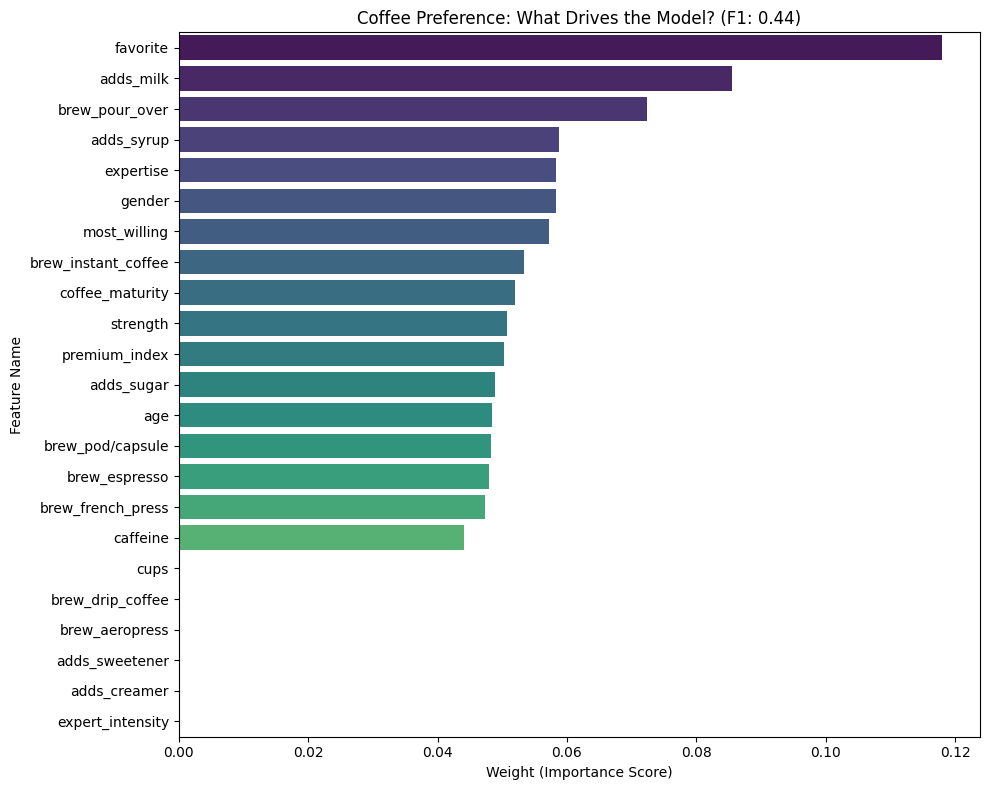

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Extract importance and map to column names
importances = model.feature_importances_
feature_names = x_train_final.columns # Ensure this matches your final training set

# 2. Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Coffee Preference: What Drives the Model? (F1: 0.44)')
plt.xlabel('Weight (Importance Score)')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [123]:
# 1. Create the combined feature
# We sum them up: 0 = Black, 1 = One addition, 2 = Sweetened & Creamy, 3 = The Works
x_train_final['sweetened_behavior'] = (
    x_train_final['adds_sugar'] +
    x_train_final['adds_syrup'] +
    x_train_final['adds_milk']
)

x_test_final['sweetened_behavior'] = (
    x_test_final['adds_sugar'] +
    x_test_final['adds_syrup'] +
    x_test_final['adds_milk']
)

# 2. Re-fit the model with the new feature
model.fit(x_train_final, y_train, sample_weight=weights)

# 3. Check the new F1-Score
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_final)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       506
           1       0.32      0.45      0.37       157
           2       0.23      0.29      0.26       146

    accuracy                           0.52       809
   macro avg       0.44      0.45      0.43       809
weighted avg       0.58      0.52      0.54       809

